<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/unstructured_nougat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install torch huggingface_hub python-dotenv transformers sentence-transformers pymupdf langchain langchain-community langchain-huggingface chromadb tqdm unidecode gradio bitsandbytes seaborn

  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
Using cached aiofiles-23.2.1-py3-none-any.whl (15 kB)
  Attempting uninstall: aiofiles
    Found existing installation: aiofiles 24.1.0
    Uninstalling aiofiles-24.1.0:
      Successfully uninstalled aiofiles-24.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unstructured-client 0.28.1 requires aiofiles>=24.1.0, but you have aiofiles 23.2.1 which is incompatible.


In [2]:
!pip install -q pymupdf python-Levenshtein nltk
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!apt-get install poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [4]:
!pip install unstructured[pdf]

  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
  Attempting uninstall: aiofiles
    Found existing installation: aiofiles 23.2.1
    Uninstalling aiofiles-23.2.1:
      Successfully uninstalled aiofiles-23.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.9.1 requires aiofiles<24.0,>=22.0, but you have aiofiles 24.1.0 which is incompatible.


In [5]:
import os
import torch
from huggingface_hub import login
from dotenv import load_dotenv
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from sentence_transformers import SentenceTransformer
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import time
from tqdm import tqdm
import re
import gradio as gr
from unidecode import unidecode
import random

In [6]:
import nltk

print(nltk.__version__)  # confirm you see 3.9.1, otherwise restart session

nltk.download("punkt")

3.9.1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
#!wget -O local_copy.pdf https://arxiv.org/pdf/1706.03762.pdf

In [8]:
PDF_NAME = "IR Slides v1.0.pdf"
running_on_colab = False

try:
    import gdown
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("Running in Google Colab. Using userdata to get HF_TOKEN.")
    # save locally from https://drive.google.com/file/d/1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY/view?usp=drive_link
    #gdown.download(id="1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY", output=PDF_NAME, quiet=False)
    # cutted version: https://drive.google.com/file/d/1rO-Egw84aKTK-534CIm4Qpmy5ehehyaM/view?usp=drive_link
    gdown.download(id="1rO-Egw84aKTK-534CIm4Qpmy5ehehyaM", output=PDF_NAME, quiet=False)
    running_on_colab = True
except ModuleNotFoundError:
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')
    print("Not running in Google Colab. Using load_dotenv to get HF_TOKEN.")

file_path = PDF_NAME
login(token=HF_TOKEN)

Running in Google Colab. Using userdata to get HF_TOKEN.


Downloading...
From: https://drive.google.com/uc?id=1rO-Egw84aKTK-534CIm4Qpmy5ehehyaM
To: /content/IR Slides v1.0.pdf
100%|██████████| 130k/130k [00:00<00:00, 4.62MB/s]


In [116]:
from unstructured.partition.auto import partition

file_name = "IR Slides v1.0.pdf"

title = "Information Retrival"
elements = partition(
    filename=file_name,
    strategy="hi_res",
    skip_infer_table_types=[],
    include_page_breaks=True,
)

In [143]:
from unstructured.documents.elements import Title, NarrativeText, Image, Formula, PageBreak

print(len(elements))

print(elements)

print("\n\n")
for element in elements:
  if isinstance(element, Image):
    print(element)

print("\n\n")
for element in elements:
  if isinstance(element, Formula):
    print(element)

print("\n\n")
for element in elements:
  if isinstance(element, PageBreak):
    print("break")

43
[<unstructured.documents.elements.Title object at 0x7f0f05f9dde0>, <unstructured.documents.elements.ListItem object at 0x7f0f05ce5f30>, <unstructured.documents.elements.Image object at 0x7f0ea51c9990>, <unstructured.documents.elements.NarrativeText object at 0x7f0ea51c94e0>, <unstructured.documents.elements.PageBreak object at 0x7f0f06390f70>, <unstructured.documents.elements.Title object at 0x7f0ea51caa10>, <unstructured.documents.elements.Title object at 0x7f0ea51c9420>, <unstructured.documents.elements.Formula object at 0x7f0ee88686d0>, <unstructured.documents.elements.NarrativeText object at 0x7f0ee8869f90>, <unstructured.documents.elements.Title object at 0x7f0f2a7034f0>, <unstructured.documents.elements.Formula object at 0x7f0ee88690f0>, <unstructured.documents.elements.ListItem object at 0x7f104bd61e70>, <unstructured.documents.elements.Formula object at 0x7f0ee886acb0>, <unstructured.documents.elements.NarrativeText object at 0x7f0ee886bfa0>, <unstructured.documents.elements

In [144]:
type_value_elements = []

for i in range(len(elements)):
  pair = [type(elements[i]), elements[i].text]
  type_value_elements.append(pair)

# print type_value_elements as a table
import pandas as pd
df_elements = pd.DataFrame(type_value_elements, columns=['Type', 'Value'])
print(df_elements)


                                                 Type  \
0     <class 'unstructured.documents.elements.Title'>   
1   <class 'unstructured.documents.elements.ListIt...   
2     <class 'unstructured.documents.elements.Image'>   
3   <class 'unstructured.documents.elements.Narrat...   
4   <class 'unstructured.documents.elements.PageBr...   
5     <class 'unstructured.documents.elements.Title'>   
6     <class 'unstructured.documents.elements.Title'>   
7   <class 'unstructured.documents.elements.Formula'>   
8   <class 'unstructured.documents.elements.Narrat...   
9     <class 'unstructured.documents.elements.Title'>   
10  <class 'unstructured.documents.elements.Formula'>   
11  <class 'unstructured.documents.elements.ListIt...   
12  <class 'unstructured.documents.elements.Formula'>   
13  <class 'unstructured.documents.elements.Narrat...   
14  <class 'unstructured.documents.elements.PageBr...   
15    <class 'unstructured.documents.elements.Title'>   
16    <class 'unstructured.docu

In [145]:
from unstructured.documents.elements import Title, NarrativeText, Image, Formula, PageBreak

# print df_elements for rows with Type Image or Formula
print(df_elements[df_elements['Type'].isin([Image, Formula])])

                                                 Type  \
2     <class 'unstructured.documents.elements.Image'>   
7   <class 'unstructured.documents.elements.Formula'>   
10  <class 'unstructured.documents.elements.Formula'>   
12  <class 'unstructured.documents.elements.Formula'>   

                                                Value  
2   Bj =  (  (1 − b) + b  dlj  avdl )   with   0 ≤...  
7                              tf′ i(dj) = tfi(dj) Bj  
10  cBM25 i (tfi, dj) = cBM1 i tf′ i(dj) k1 + tf′ ...  
12  RSVBM25(q, d) = ∑ ti∈q k1( tfi(d) (1 − b) + b ...  


In [146]:
# print the row 18 of df_elements
print(df_elements.iloc[18])

Type     <class 'unstructured.documents.elements.Narrat...
Value    s(q, d) = wtitle ⋅ s(q, dtitle) + wbody ⋅ s(q,...
Name: 18, dtype: object


In [147]:
page_with_formula_indexes = []

# dictionary to store the number of formula for each page
number_of_formulas_per_page = {}
locations_with_formula_at_page = {}

index = 0  # first page -> index = 0

# iterate over df_elements
for i in range(len(df_elements)):
  if df_elements.iloc[i]['Type'] == PageBreak:
    index += 1
  if df_elements.iloc[i]['Type'] == Formula or df_elements.iloc[i]['Type'] == Image:
    # saving in dictionary the dataframe locations with formula/image for that page
    if index not in locations_with_formula_at_page:
      locations_with_formula_at_page[index] = [i]
    else:
      locations_with_formula_at_page[index].append(i)
    # saving in dictionary the number of formula/image for that page
    if index not in number_of_formulas_per_page:
      number_of_formulas_per_page[index] = 1
    else:
      number_of_formulas_per_page[index] += 1
    if index not in page_with_formula_indexes:
      page_with_formula_indexes.append(index)

print(page_with_formula_indexes)

[0, 1]


In [148]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

# Load the Nougat model and processor from the hub
processor = AutoProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    896,
    672
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "qkv_bias": true,
  "transformers_version": "4.48.0.dev0",
  "use_absolute_embeddings": false,
  "window_size": 7
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_final_layer_norm":

In [149]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [150]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

2


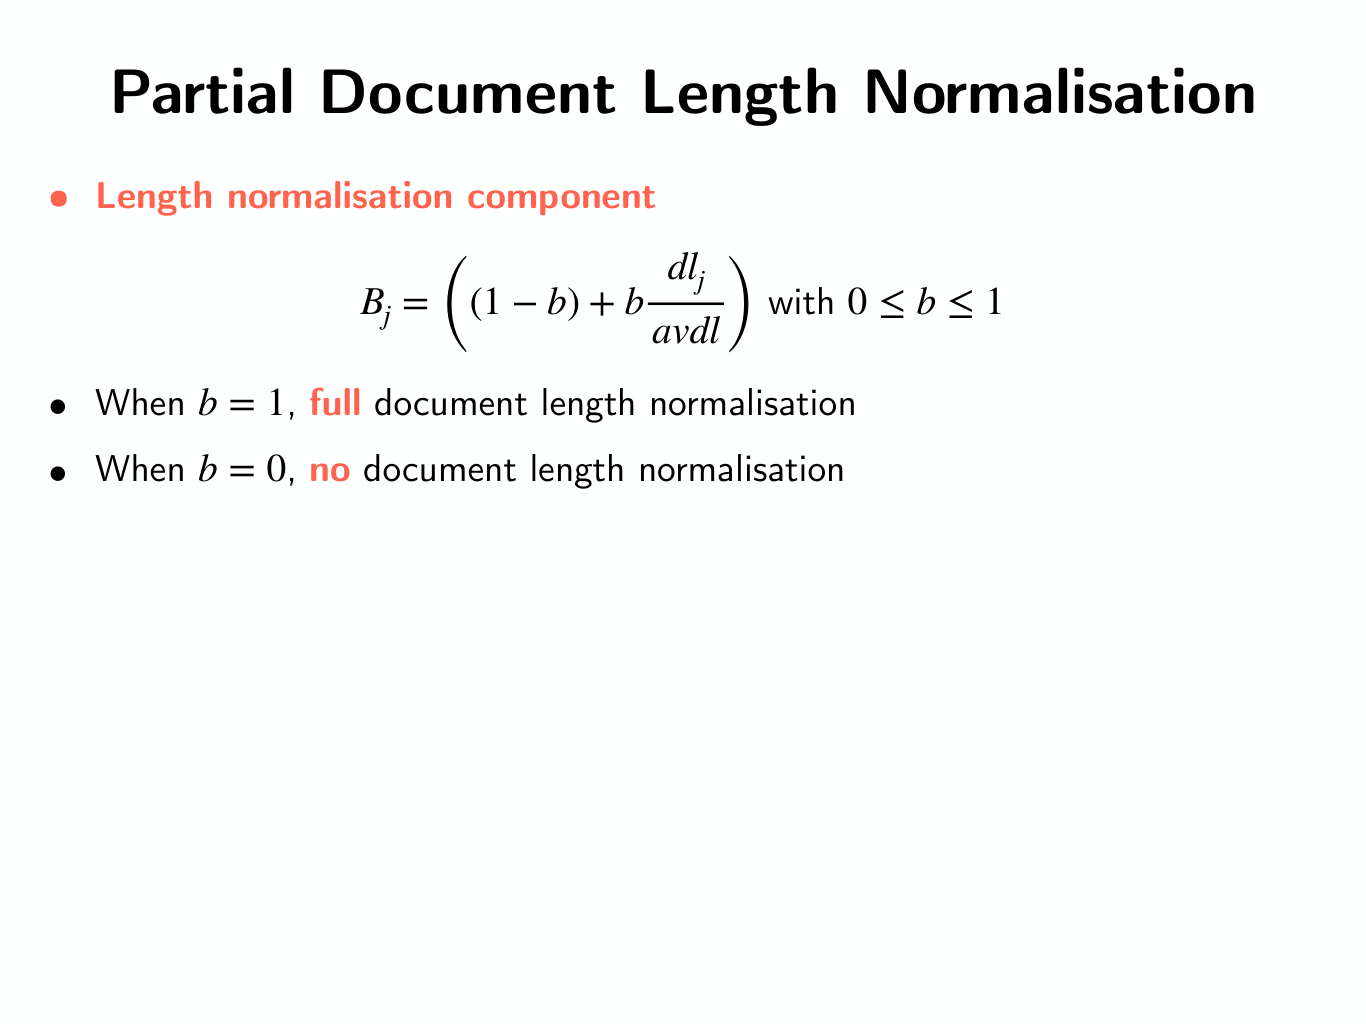

In [151]:
from huggingface_hub import hf_hub_download
from typing import Optional, List
import io
import fitz
from pathlib import Path
from PIL import Image

#filepath = hf_hub_download(repo_id="inuwamobarak/random-files", filename="2310.08535.pdf", repo_type="dataset")

images = rasterize_paper(pdf=file_name, return_pil=True, pages=page_with_formula_indexes)

print(len(images))

image = Image.open(images[0])
image


In [152]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [153]:
outputs = []

print(len(images))

for i in range(len(images)):

  image = Image.open(images[i])

  pixel_values = processor(images=image, return_tensors="pt").pixel_values

  outputs.append(
        model.generate(
        pixel_values.to(device),
        min_length=1,
        max_length=3584,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True,
        stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
    )
  )

print(len(outputs))

2


<ipython-input-152-1f2d56ef631f>:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  return torch.var(self.values, 1) / self.values.shape[1]


2


In [154]:
def formulas_extraction(latex_text):
  #pattern_inline_paren = r'\\\((.*?)\\\)'    # matches \( ... \)
  pattern_display_paren = r'\\\[(.*?)\\\]'   # matches \[ ... \]

  # Extract matches
  #inline_paren = re.findall(pattern_inline_paren, latex_text, flags=re.DOTALL)
  display_paren = re.findall(pattern_display_paren, latex_text, flags=re.DOTALL)

  # Combine all results into a single list
  formulas = display_paren
  return formulas


In [155]:
for i in range(len(outputs)):

  generated = processor.batch_decode(outputs[i][0], skip_special_tokens=True)[0]
  generated = processor.post_process_generation(generated, fix_markdown=False)
  print(generated)
  print("\n")

  formulas = formulas_extraction(generated)

  # we have to extract number_of_formulas_per_page[i]
  for j in range(number_of_formulas_per_page[i]):
    print(formulas[j])

    # replace in df_elements
    df_elements.at[locations_with_formula_at_page[i][j], 'Value'] = formulas[j]

Partial Document Length Normalisation

* Length normalisation component \[B_{j}=\left((1-b)+b\frac{dl_{j}}{avdl}\right)\text{ with }0\leq b\leq 1\]
* When \(b=1\), full document length normalisation
* When \(b=0\), no document length normalisation 


B_{j}=\left((1-b)+b\frac{dl_{j}}{avdl}\right)\text{ with }0\leq b\leq 1


**Okapi BM25**

* The term frequency \(tf_{i}^{\prime}\) can be represented as a normalised value with respect to the document length normalisation component \(B_{j}\) \[tf_{i}^{\prime}(d_{j})=\frac{tf_{i}^{\prime}(d_{j})}{B_{j}}\]
* Plugging this in the BM15 formula, we get the best match 25 (BM25) weights \[c_{i}^{\text{BM25}}(tf_{i},d_{j})=c_{i}^{\text{BM1}}\frac{tf_{i}^{\prime}(d_{j })}{k_{1}+tf_{i}^{\prime}(d_{j})}=c_{i}^{\text{BM1}}\frac{tf_{i}(d_{j})}{k_{1} B_{j}+tf_{i}(d_{j})}\]
* So, the BM25 RSV score is, at last: \[RSV^{\text{BM25}}(q,d)=\sum_{t_{i}\in q}\frac{tf_{i}(d)}{k_{1}\bigg{(}(1-b)+b \frac{dl(d)}{avdl}\bigg{)}+tf_{i}^{\prime}(d)}\log\frac{N}{n_{i}}

In [156]:
from unstructured.documents.elements import Title, NarrativeText, Image, Formula, PageBreak

# print df_elements for rows with Type Image or Formula
print(df_elements[df_elements['Type'].isin([Image, Formula])])

                                                 Type  \
2     <class 'unstructured.documents.elements.Image'>   
7   <class 'unstructured.documents.elements.Formula'>   
10  <class 'unstructured.documents.elements.Formula'>   
12  <class 'unstructured.documents.elements.Formula'>   

                                                Value  
2   B_{j}=\left((1-b)+b\frac{dl_{j}}{avdl}\right)\...  
7   tf_{i}^{\prime}(d_{j})=\frac{tf_{i}^{\prime}(d...  
10  c_{i}^{\text{BM25}}(tf_{i},d_{j})=c_{i}^{\text...  
12  RSV^{\text{BM25}}(q,d)=\sum_{t_{i}\in q}\frac{...  
